# Dataset

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%load_ext autoreload
%autoreload 2

In [2]:
required_libs = [ ("numpy", "numpy"),
                 ("pandas", "pandas"),
                 ("seaborn", "seaborn"),
                 ("matplotlib", "matplotlib"),
                 ("sklearn", "sklearn"),
                 ("colorama", "colorama"),
                 ("emoji", "emoji"),
                 #("catboost", "catboost")
                ]

In [3]:
def is_lib_exists(name):
    import importlib
    lib = importlib.util.find_spec(name)
    return lib is not None

In [4]:
for (clz,lib) in required_libs:
    if not is_lib_exists(clz):
        print(f"Installing {lib}")
        !pip -qq install {lib}
    else:
        print(f"{lib} exists")

numpy exists
pandas exists
seaborn exists
matplotlib exists
sklearn exists
colorama exists
emoji exists


In [5]:
# Uninstall fastai ver 1 and install ver 2
!pip uninstall -qq --yes fastai 
!pip install -q fastai
!pip install -q nbdev
import fastai
print(fastai.__version__)

2.0.15


In [6]:
COLAB = True

DATASET_NAME = '4D.zip'

FEATURE_DATASET_PREFIX = 'feature_matrix_d2_v3'

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import calendar
import traceback
# import catboost
import gc
from pathlib import Path
from dateutil.relativedelta import *
from datetime import *
#from catboost import *
#from catboost import datasets
#from catboost import CatBoostClassifier
from scipy import stats
from scipy.stats.stats import pearsonr
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.metrics import roc_auc_score
np.set_printoptions(precision=4)
pd.options.display.max_columns = None

In [8]:
%matplotlib inline
%aimport

Modules to reload:
all-except-skipped

Modules to skip:



In [9]:
from IPython.display import display

In [10]:
# check catboost version
# print(catboost.__version__)
# !python --version

In [11]:
# colab setup
if COLAB:
  !rm -rf dl-projects
  !git clone https://github.com/mengwangk/dl-projects
  
  !cp dl-projects/utils* .
  !cp dl-projects/preprocess* .
  !cp dl-projects/plot* .
  
  from google.colab import drive
  drive.mount('/content/gdrive')
  GDRIVE_DATASET_FOLDER = Path('gdrive/My Drive/datasets/')
  DATASET_PATH = GDRIVE_DATASET_FOLDER
  ORIGIN_DATASET_PATH = Path('dl-projects/datasets')
  #!ls -l gdrive/"My Drive"/datasets/ --block-size=M

DATASET = DATASET_PATH/f"{FEATURE_DATASET_PREFIX}.ft"
ORIGIN_DATASET = ORIGIN_DATASET_PATH/DATASET_NAME

Cloning into 'dl-projects'...
remote: Enumerating objects: 146, done.
remote: Counting objects: 100% (146/146), done.
remote: Compressing objects: 100% (129/129), done.
remote: Total 2356 (delta 91), reused 33 (delta 17), pack-reused 2210
Receiving objects: 100% (2356/2356), 80.59 MiB | 11.51 MiB/s, done.
Resolving deltas: 100% (1470/1470), done.
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## EDA

In [12]:
from preprocess import *
from utils import feature_selection, plot_feature_importances
from plot import plot_correlation_matrix, plot_labeled_scatter

In [13]:
data = pd.read_feather(DATASET)
origin_data = format_tabular(ORIGIN_DATASET)

In [14]:
jan_2020 = pd.read_feather(DATASET_PATH/f"feature_matrix_2020_jan.ft")
feb_2020 = pd.read_feather(DATASET_PATH/f"feature_matrix_2020_feb.ft")
mar_2020 = pd.read_feather(DATASET_PATH/f"feature_matrix_2020_mar.ft")
apr_2020 = pd.read_feather(DATASET_PATH/f"feature_matrix_2020_apr.ft")
may_2020 = pd.read_feather(DATASET_PATH/f"feature_matrix_2020_may.ft")
jun_2020 = pd.read_feather(DATASET_PATH/f"feature_matrix_2020_jun.ft")
jul_2020 = pd.read_feather(DATASET_PATH/f"feature_matrix_2020_jul.ft")

In [15]:
new_data = data.append(jan_2020[data.columns],ignore_index=True)
new_data = new_data.append(feb_2020[data.columns],ignore_index=True)
new_data = new_data.append(mar_2020[data.columns],ignore_index=True)
new_data = new_data.append(apr_2020[data.columns],ignore_index=True)
new_data = new_data.append(may_2020[data.columns],ignore_index=True)
new_data = new_data.append(jun_2020[data.columns],ignore_index=True)
new_data = new_data.append(jul_2020[data.columns],ignore_index=True)
data.shape, new_data.shape 

((959893, 217), (1029893, 217))

In [16]:
del data
data = new_data

In [17]:
data.isna().sum().sort_values(ascending=False)

CUM_SUM(SKEW(Results.TotalStrike))           7685
CUM_MEAN(TREND(Results.DrawNo, DrawDate))    7685
TREND(Results.CUM_SUM(DrawNo), DrawDate)     7685
TREND(Results.CUM_SUM(LuckyNo), DrawDate)    7685
CUM_SUM(SKEW(Results.LuckyNo))               7685
                                             ... 
CUM_SUM(MIN(Results.DrawNo))                    0
NUM_UNIQUE(Results.DAY(DrawDate))               0
NUM_UNIQUE(Results.MONTH(DrawDate))             0
SUM(Results.PERCENTILE(LuckyNo))                0
NumberId                                        0
Length: 217, dtype: int64

In [18]:
# data.info(max_cols=500, null_counts=True)
# data.columns.tolist()

In [19]:
feature_matrix = data

### fastai to handle missing values
# feature_matrix = data.fillna(0)
# feature_matrix.sort_values(by=['time', 'MAX(Results.LuckyNo)'], inplace=True)
# feature_matrix.head(20)

In [20]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, chi2, f_regression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold

# other_features = ['Label', 'NumberId', 'time', 'TotalStrike',  'month', 'year']
# feature_matrix = feature_selection(data)

def select_features(df, func=f_regression):
  X = df.drop(columns=other_features)
  y = df.Label
  fs = SelectKBest(score_func=func, k=50)
  X_selected = fs.fit_transform(X, y)
  mask = fs.get_support()
  return X.columns[mask]

def reduce_features(df, lower_threshold=10, upper_threshold=10000):
  cols_to_drop = []
  for col in df.columns:
    if df[col].nunique() > upper_threshold or df[col].nunique() < lower_threshold:
      cols_to_drop.append(col)
  print(cols_to_drop)
  return cols_to_drop, df.drop(columns=cols_to_drop)

def select_by_variance(df, threshold=0):
  """Select features by variance"""
  filter = VarianceThreshold(threshold=threshold)
  filter.fit(df)
  cols_to_drop = [column for column in df.columns
                  if column not in df.columns[filter.get_support()]]
  print(f"No of columns to drop - {len(cols_to_drop)}")
  print(cols_to_drop)
  return cols_to_drop

def select_duplicates(df):
  df_transposed = df.head(20000).T
  print(df_transposed.duplicated().sum())
  unique_features = df_transposed.drop_duplicates(keep='first').T
  print(unique_features.shape)
  duplicated_features = [dup_col for dup_col in df.columns if dup_col not in unique_features.columns]
  return duplicated_features

def select_correlated(df):
  correlated_features = set()
  correlation_matrix = df.corr()
  for i in range(len(correlation_matrix .columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
  print(len(correlated_features))
  print(correlated_features)
  return correlated_features


In [21]:
selected_features = feature_matrix.columns.to_list()
# display(len(selected_features), selected_features)
print(len(selected_features))

217


In [22]:
df_selected_features = feature_matrix[selected_features]

In [23]:
# def split_data(df, dt):
#   y_train = df.loc[df['time'] < dt, 'Label']
#   y_validation = df.loc[df['time'] == dt, 'Label']
# 
#   X_train = df[df['time'] < dt].drop(columns = ['NumberId', 'time', 'Label', 'TotalStrike', 'year', 'month'])
#   X_validation = df[df['time'] == dt].drop(columns = ['NumberId', 'time', 'Label', 'TotalStrike', 'year', 'month'])
# 
#   # Reduce by standard deviation
#   # X_train = X_train.loc[:, X_train.std() > .0]
#   # X_validation = X_validation[X_train.columns]
# 
#   return X_train, X_validation, y_train, y_validation

In [24]:
TARGET_DT = datetime(2020,1,1)

# X_train, X_validation, y_train, y_validation = split_data(df_selected_features, TARGET_MONTH)
# X_train.shape, X_validation.shape, y_train.shape, y_validation.shape

In [25]:
# cols_to_drop = select_by_variance(X_train,0.0)
# X_train = X_train.drop(columns=cols_to_drop)
# X_validation = X_validation[X_train.columns]
# X_train.shape, X_validation.shape
# 
# cols_to_drop = select_by_variance(X_train,0.01)
# X_train = X_train.drop(columns=cols_to_drop)
# X_validation = X_validation[X_train.columns]
# X_train.shape, X_validation.shape
# 
# cols_to_drop = select_duplicates(X_train)
# X_train = X_train.drop(columns=cols_to_drop)
# X_validation = X_validation[X_train.columns]
# X_train.shape, X_validation.shape
# 
# cols_to_drop = select_correlated(X_train)
# X_train = X_train.drop(columns=cols_to_drop)
# X_validation = X_validation[X_train.columns]
# X_train.shape, X_validation.shape

In [26]:
# CAT_FEATURES = []
# UNIQUE_THRESHOLD = 500
# for col in X_train.select_dtypes(include=['int64']).columns:
#   print(f"{col}: Index - {X_train.columns.get_loc(col)}, Unique values - {X_train[col].nunique()}")
#   if X_train[col].nunique() <= UNIQUE_THRESHOLD:
#     CAT_FEATURES.append(X_train.columns.get_loc(col))
#   
# print(CAT_FEATURES)

In [27]:
df_selected_features.columns

Index(['NumberId', 'time', 'STD(Results.DrawNo)', 'STD(Results.TotalStrike)',
       'STD(Results.LuckyNo)', 'MAX(Results.DrawNo)',
       'MAX(Results.TotalStrike)', 'MAX(Results.LuckyNo)',
       'MIN(Results.DrawNo)', 'MIN(Results.TotalStrike)',
       ...
       'PERCENTILE(SUM(Results.DrawNo))',
       'PERCENTILE(TREND(Results.DrawNo, DrawDate))',
       'PERCENTILE(LAST(Results.LuckyNo))', 'PERCENTILE(MAX(Results.LuckyNo))',
       'TotalStrike', 'Label', 'MODE(Results.PrizeType)_Prize',
       'LAST(Results.PrizeType)_Prize', 'month', 'year'],
      dtype='object', length=217)

In [28]:
cols_to_drop = select_by_variance(df_selected_features.drop(columns=['Label', 'NumberId', 'time', 'TotalStrike',  'month', 'year']), 0.01)

No of columns to drop - 68
['STD(Results.TotalStrike)', 'STD(Results.LuckyNo)', 'MAX(Results.TotalStrike)', 'MIN(Results.TotalStrike)', 'MEAN(Results.TotalStrike)', 'SKEW(Results.TotalStrike)', 'SKEW(Results.LuckyNo)', 'LAST(Results.TotalStrike)', 'TREND(Results.TotalStrike, DrawDate)', 'TREND(Results.LuckyNo, DrawDate)', 'TREND(Results.DrawNo, DrawDate)', 'NUM_UNIQUE(Results.PrizeType)', 'STD(Results.PERCENTILE(DrawNo))', 'STD(Results.PERCENTILE(TotalStrike))', 'STD(Results.CUM_MEAN(TotalStrike))', 'STD(Results.PERCENTILE(LuckyNo))', 'MAX(Results.PERCENTILE(TotalStrike))', 'MAX(Results.CUM_MEAN(TotalStrike))', 'MIN(Results.PERCENTILE(TotalStrike))', 'MIN(Results.CUM_MEAN(TotalStrike))', 'MEAN(Results.PERCENTILE(TotalStrike))', 'MEAN(Results.CUM_MEAN(TotalStrike))', 'SKEW(Results.PERCENTILE(TotalStrike))', 'SKEW(Results.CUM_MEAN(TotalStrike))', 'SKEW(Results.PERCENTILE(LuckyNo))', 'LAST(Results.PERCENTILE(TotalStrike))', 'LAST(Results.CUM_MEAN(TotalStrike))', 'TREND(Results.CUM_MEAN(Lu

In [29]:
# Prepare the data
# unused_features = ['NumberId', 'time', 'TotalStrike',  'month', 'year']
unused_features = ['time', 'TotalStrike'] + cols_to_drop
print("Columns to drop ", unused_features)
df = df_selected_features.drop(columns=unused_features)

Columns to drop  ['time', 'TotalStrike', 'STD(Results.TotalStrike)', 'STD(Results.LuckyNo)', 'MAX(Results.TotalStrike)', 'MIN(Results.TotalStrike)', 'MEAN(Results.TotalStrike)', 'SKEW(Results.TotalStrike)', 'SKEW(Results.LuckyNo)', 'LAST(Results.TotalStrike)', 'TREND(Results.TotalStrike, DrawDate)', 'TREND(Results.LuckyNo, DrawDate)', 'TREND(Results.DrawNo, DrawDate)', 'NUM_UNIQUE(Results.PrizeType)', 'STD(Results.PERCENTILE(DrawNo))', 'STD(Results.PERCENTILE(TotalStrike))', 'STD(Results.CUM_MEAN(TotalStrike))', 'STD(Results.PERCENTILE(LuckyNo))', 'MAX(Results.PERCENTILE(TotalStrike))', 'MAX(Results.CUM_MEAN(TotalStrike))', 'MIN(Results.PERCENTILE(TotalStrike))', 'MIN(Results.CUM_MEAN(TotalStrike))', 'MEAN(Results.PERCENTILE(TotalStrike))', 'MEAN(Results.CUM_MEAN(TotalStrike))', 'SKEW(Results.PERCENTILE(TotalStrike))', 'SKEW(Results.CUM_MEAN(TotalStrike))', 'SKEW(Results.PERCENTILE(LuckyNo))', 'LAST(Results.PERCENTILE(TotalStrike))', 'LAST(Results.CUM_MEAN(TotalStrike))', 'TREND(Result

In [30]:
# Target label. No need to np.log
dep_var = 'Label'

# Train test split
procs = [Categorify, FillMissing, Normalize]
train_cond = (df.year < TARGET_DT.year) | (df.month < TARGET_DT.month)
valid_cond = (df.year == TARGET_DT.year) & (df.month == TARGET_DT.month)
train_idx = np.where(train_cond)[0]
valid_idx = np.where(valid_cond)[0]
splits = (list(train_idx),list(valid_idx))

In [31]:
print(list(train_idx)[len(list(train_idx))-1])
print(list(valid_idx)[0], list(valid_idx)[len(list(valid_idx))-1])

959892
959893 969892


In [32]:
df[dep_var] = df[dep_var].astype('category')

In [33]:
# Continuous and categorical variables
cont,cat = cont_cat_split(df, max_card=9000, dep_var=dep_var)
print("Continous features: ", len(cont))
print("Categorical features:", len(cat))

Continous features:  129
Categorical features: 17


In [34]:
#gc.collect() # Garbage collect

to = TabularPandas(df, procs=procs, cat_names=cat, cont_names=cont, y_names=dep_var, splits=splits)
len(to.train),len(to.valid)

(959893, 10000)

In [35]:
dls = to.dataloaders(1024)

In [36]:
#y = to.train.y
#y.min(),y.max()

del feature_matrix
del new_data
#del df_selected_features
del jan_2020
del feb_2020
del mar_2020
del apr_2020
del may_2020
del jun_2020
del jul_2020

In [37]:
# doc(tabular_learner)

# View Transformed Training/Validation Data
# dls.xs

#####################
# Construct Weights #
#####################
# class_count_df = df.groupby(dep_var).count()
#n_0, n_1 = class_count_df.iloc[0, 0], class_count_df.iloc[1, 0]

n_0, n_1 = df[dep_var].value_counts()[0], df[dep_var].value_counts()[1]
print(n_0, n_1)

w_0 = (n_0 + n_1) / (2.0 * n_0)
w_1 = (n_0 + n_1) / (2.0 * n_1)
print(w_0, w_1)

996848 33045
0.5165747435918013 15.583189589953093


In [38]:
# Important: Convert Weights To Float Tensor
class_weights=torch.FloatTensor([w_0, w_1]).cuda()

############################
# Model Performance Metric #
############################
# Instantiate RocAucBinary Score
roc_auc = RocAucBinary() # Very important: Use the binary scoring function and not RocAuc()

#################
# Loss Function #
#################
loss_func = CrossEntropyLossFlat(weight=class_weights)

In [62]:
def calcHiddenLayer(data, alpha, numHiddenLayers):
  tempData = data.train_ds
  #i, o = len(tempData.x.classes), len(tempData.y.classes)
  #io = i+o
  io = len(tempData.classes)
  print(io)
  return [(len(data.train_ds)//(alpha*(io)))//numHiddenLayers]*numHiddenLayers

In [64]:
layers = calcHiddenLayer(dls, 3, 3)
print(layers)

48
[2221, 2221, 2221]


In [58]:
#dls.train_ds.classes

{'AVG_TIME_BETWEEN(Results.DrawDate)_na': (#3) ['#na#',False,True],
 'COUNT(Results)': (#28) ['#na#',1,2,3,4,5,6,7,8,9...],
 'CUM_MEAN(AVG_TIME_BETWEEN(Results.DrawDate))_na': (#3) ['#na#',False,True],
 'CUM_MEAN(STD(Results.DrawNo))_na': (#3) ['#na#',False,True],
 'CUM_SUM(AVG_TIME_BETWEEN(Results.DrawDate))_na': (#3) ['#na#',False,True],
 'CUM_SUM(SKEW(Results.DrawNo))_na': (#3) ['#na#',False,True],
 'CUM_SUM(STD(Results.DrawNo))_na': (#3) ['#na#',False,True],
 'CUM_SUM(TREND(Results.DrawNo, DrawDate))_na': (#3) ['#na#',False,True],
 'DAY(LAST(Results.DrawDate))': (#32) ['#na#',1,2,3,4,5,6,7,8,9...],
 'DAY(first_Results_time)': (#32) ['#na#',1,2,3,4,5,6,7,8,9...],
 'LAST(Results.DAY(DrawDate))': (#32) ['#na#',1,2,3,4,5,6,7,8,9...],
 'LAST(Results.DrawNo)': (#3023) ['#na#',43992,46192,53093,56793,60393,67994,72494,73994,77594...],
 'LAST(Results.MONTH(DrawDate))': (#13) ['#na#',1,2,3,4,5,6,7,8,9...],
 'MAX(Results.DrawNo)': (#3023) ['#na#',43992,46192,53093,56793,60393,67994,72494,739

In [41]:
#learn = tabular_learner(dls, y_range=(0,1), layers=[500,250], metrics=[accuracy], loss_func=F.binary_cross_entropy)
#learn = tabular_learner(dls, loss_func=loss_func, metrics=roc_auc)
config = tabular_config(ps=[0.001,0.01, 0.1], embed_p=0.04)
learn = tabular_learner(dls, layers=[1000, 500,250], loss_func=loss_func, metrics=roc_auc, config=config)
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(3023, 142)
    (1): Embedding(1597, 100)
    (2): Embedding(3023, 142)
    (3): Embedding(28, 10)
    (4): Embedding(28, 10)
    (5): Embedding(13, 7)
    (6): Embedding(32, 11)
    (7): Embedding(13, 7)
    (8): Embedding(32, 11)
    (9): Embedding(32, 11)
    (10): Embedding(13, 7)
    (11): Embedding(13, 7)
    (12): Embedding(21, 9)
    (13): Embedding(13, 7)
    (14): Embedding(32, 11)
    (15): Embedding(13, 7)
    (16): Embedding(9, 5)
    (17): Embedding(3, 3)
    (18): Embedding(3, 3)
    (19): Embedding(3, 3)
    (20): Embedding(3, 3)
    (21): Embedding(3, 3)
    (22): Embedding(3, 3)
    (23): Embedding(3, 3)
    (24): Embedding(3, 3)
    (25): Embedding(3, 3)
    (26): Embedding(3, 3)
    (27): Embedding(3, 3)
    (28): Embedding(3, 3)
    (29): Embedding(3, 3)
    (30): Embedding(3, 3)
    (31): Embedding(3, 3)
    (32): Embedding(3, 3)
    (33): Embedding(3, 3)
    (34): Embedding(3, 3)
    (35): Embedding(3, 3)
  

SuggestedLRs(lr_min=7.585775892948732e-06, lr_steep=0.12022644281387329)

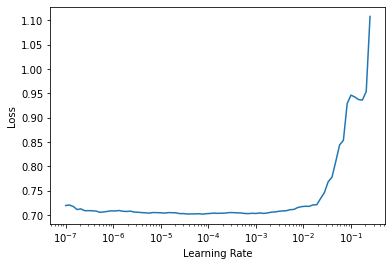

In [42]:
learn.lr_find()

In [43]:
doc(tabular_learner)

In [44]:
doc(TabularPandas)

In [45]:
learn.fit_one_cycle(30, 1e-4)

epoch,train_loss,valid_loss,roc_auc_score,time
0,0.699635,0.685303,0.486958,00:36
1,0.691938,0.677681,0.476012,00:36
2,0.683676,0.666420,0.469098,00:37
3,0.664384,0.648237,0.485095,00:37
4,0.647310,0.655389,0.525122,00:36
5,0.625673,0.539335,0.496339,00:37
6,0.604858,0.621820,0.496735,00:36
7,0.573860,0.563793,0.512581,00:38
8,0.540585,0.539562,0.497003,00:37
9,0.511196,0.542601,0.499055,00:37


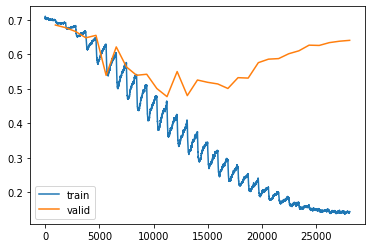

In [46]:
learn.recorder.plot_loss()

In [47]:
cls = ClassificationInterpretation.from_learner(learn)

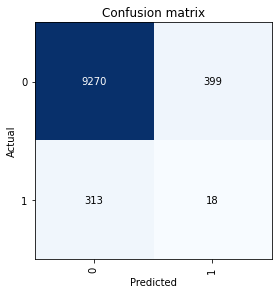

In [48]:
cls.plot_confusion_matrix()

In [49]:
preds,targs = learn.get_preds()
print(len(preds), len(targs))

10000 10000


In [50]:
print(preds)

tensor([[0.9549, 0.0451],
        [0.9701, 0.0299],
        [0.9972, 0.0028],
        ...,
        [0.9790, 0.0210],
        [0.9944, 0.0056],
        [0.9742, 0.0258]])


In [51]:
print(targs)

tensor([[1],
        [1],
        [1],
        ...,
        [0],
        [0],
        [0]], dtype=torch.int8)


In [52]:
# https://www.kaggle.com/osmano/fast-ai-tabular-library/notebook
# https://nbviewer.jupyter.org/github/fastai/fastbook/blob/master/09_tabular.ipynb
# https://catboost.ai/docs/concepts/python-reference_utils_select_threshold.html
# https://forums.fast.ai/t/some-useful-functions-for-tabular-models/44044
# https://stackoverflow.com/questions/41864083/how-to-set-a-threshold-for-a-sklearn-classifier-based-on-roc-results/45372522

# http://francescopochetti.com/plant-pathologies-fastais-wonders-in-computer-vision/

# https://www.kaggle.com/dromosys/fast-ai-pytorch-train-only

# https://www.kaggle.com/qitvision/a-complete-ml-pipeline-fast-ai
# https://sgugger.github.io/the-1cycle-policy.html
# https://colab.research.google.com/drive/1PVaRPY1XZuPLtm01V2XxIWqhLrz3_rgX#scrollTo=MgfhPo__CIc7
    
# https://forums.fast.ai/t/using-auc-as-metric-in-fastai/38917/19
# https://docs.fast.ai/tabular.learner#tabular_learner
# https://stackoverflow.com/questions/52093388/how-to-choose-optimal-threshold-for-class-probabilities
# https://towardsdatascience.com/deep-learning-with-weighted-cross-entropy-loss-on-imbalanced-tabular-data-using-fastai-fe1c009e184c


# https://github.com/FyzHsn/ml-classification-exploration/tree/develop
# https://github.com/FyzHsn/ml-classification-exploration/blob/develop/fastai/fastai_model.ipynb
# https://gist.githubusercontent.com/FyzHsn/28eb64cadea18f438487841f24a9739e/raw/b6830bf53337a7e62050da2d20c316b159cf581d/fastai_tabular_data_model.py

In [53]:
# doc(learn.get_preds)